# Sentimental Tweets Videos Games

L'objectif principal de ce projet est de déterminer si un type de jeu est perçu comme bon, mauvais ou neutre à partir d'un ensemble de tweets, en utilisant des modèles de traitement du langage naturel (NLP) ou de Machine Learning. <br>

Dans un premier temps, nous allons explorer et analyser le jeu de données pour mieux comprendre sa structure. Cela inclura des étapes de prétraitement des données visant à nettoyer les valeurs manquantes, éliminer les doublons et améliorer la qualité du contenu des tweets afin de mieux représenter le corpus. <br>

Ensuite, nous utiliserons une méthode de pondération des mots appelée TF-IDF (Term Frequency-Inverse Document Frequency). Cette méthode permettra d'identifier la fréquence des mots et leur importance relative pour chaque tweet. <br>

Une fois les données préparées, nous entraînerons différents modèles de Machine Learning à l'aide de la bibliothèque Scikit-learn. Ces modèles seront évalués pour identifier les plus performants à l'aide de techniques de validation croisée. <br>

Enfin, nous validerons les performances du modèle sélectionné sur un jeu de données différent. <br>

Par ailleurs, nous explorerons des outils d'interprétabilité pour analyser les prédictions du modèle. Cela nous permettra de comprendre et d'identifier les erreurs, que ce soit sur le jeu d'entraînement ou le jeu de test. <br>

https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis (Lien de téléchargement de deux datasets) <br>

## Load librairies

*Commande pour installer toute les librairies*

!pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

#NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt_tab')
nltk.download('stopwords')


##Machine Learning
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import randint

#Interprétabilité 
from sklearn.tree import export_graphviz
import graphviz
import shap

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
d:\Work\Sorbonne\ML2\Sentiment_analytics\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lecture et exploration du dataset

Le jeu de données utilisé se compose de 4 types de colonnes : <br>

L'index de la catégorie <br>
La catégorie du jeu <br>
La catégorie du sentiment <br>
Le contenu du tweet <br>

#### Phase de Nettoyage des tweets

On va supprimer la colonne l'index de la catégorie qui nous serve pas pour le moment et puis de supprimer tout les valeurs manquants, les doublons
et de retirer tout les catégories qui ne provient pas les catégories sur les jeux vidéos...

Au total, on utilise 74000 de lignes de données à traiter et à la fin on aura environ 40000 lignes de données à traiter après le nettoyage

In [2]:
data_path = "data"

In [3]:
df = pd.read_csv(f"{data_path}/twitter_training.csv",names=["index_category", "game_category","sentiment_category","Tweet"])
df_val = pd.read_csv(f"{data_path}/twitter_validation.csv",names=["index_category", "game_category","sentiment_category","Tweet"])

In [4]:
df.head()

,index_category,game_category,sentiment_category,Tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
df_val.head()

,index_category,game_category,sentiment_category,Tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index_category      74682 non-null  int64 
 1   game_category       74682 non-null  object
 2   sentiment_category  74682 non-null  object
 3   Tweet               73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   index_category      1000 non-null   int64 
 1   game_category       1000 non-null   object
 2   sentiment_category  1000 non-null   object
 3   Tweet               1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [8]:
df["sentiment_category"].describe()

count        74682
unique           4
top       Negative
freq         22542
Name: sentiment_category, dtype: object

In [9]:
df_val["sentiment_category"].describe()

count        1000
unique          4
top       Neutral
freq          285
Name: sentiment_category, dtype: object

In [10]:
print("Taille de données restant pour le jeu d'entrainement:", df.shape)
print("Taille de données restant pour le jeu de test:", df_val.shape)

Taille de données restant pour le jeu d'entrainement: (74682, 4)
Taille de données restant pour le jeu de test: (1000, 4)


On supprime l'index_category la colonne qui nous serve pas pour le moment

In [11]:
df = df.drop(columns='index_category',axis=1)
df_val = df_val.drop(columns='index_category',axis=1)

In [12]:
df.head()

,game_category,sentiment_category,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
df_val.head()

,game_category,sentiment_category,Tweet
0,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Google,Neutral,Now the President is slapping Americans in the...


On observe qu'il y a 686 de valeurs manquants sur le Tweet  0 valeur manquants sur le jeu de test 

In [14]:
print(f"Valeurs manquants sur le jeu d'entrainement:")
print(df.isnull().sum())
print("Valeurs manquants sur le jeu de test:")
print(df_val.isnull().sum())

Valeurs manquants sur le jeu d'entrainement:
game_category           0
sentiment_category      0
Tweet                 686
dtype: int64
Valeurs manquants sur le jeu de test:
game_category         0
sentiment_category    0
Tweet                 0
dtype: int64


In [15]:
print("Avant la suppression des données manquantes: ",len(df))
df = df.dropna()
print("Après la suppression des données manquantes: ",len(df))

Avant la suppression des données manquantes:  74682
Après la suppression des données manquantes:  73996


### Retirer les doublons

In [16]:
df = df.drop_duplicates()
df_val = df_val.drop_duplicates()
print("Taille de données restant pour le jeu d'entrainement:", df.shape)
print("Taille de données restant pour le jeu de test:", df_val.shape)

Taille de données restant pour le jeu d'entrainement: (70958, 3)
Taille de données restant pour le jeu de test: (1000, 3)


Retirer les catégories qui sont exclues aux noms des jeux vidéos

In [17]:
exclude_categories = ['johnson&johnson', 'Amazon','Nvidia','PlayStation5(PS5)','Xbox(Xseries)','HomeDepot','Verizon','Facebook','Google','Microsoft']

df = df[~df['game_category'].isin(exclude_categories)]
df_val = df_val[~df_val['game_category'].isin(exclude_categories)]

Retirer la catégorie Irrelevant (car il y a pas assez de données pour effectuer l'analyse des sentiments) <br>
On se base uniquement sur 3 catégories sentiments (positive, négative et neutre)

In [18]:
df = df[df['sentiment_category'] != 'Irrelevant']
df_val = df_val[df_val['sentiment_category'] != 'Irrelevant']

all_sentiments = df['sentiment_category'].unique()
all_sentiments_val = df_val['sentiment_category'].unique()

print("Liste des catégories sentiments jeu d'entrainement ",all_sentiments)
print("Liste des catégories sentiments jeu de test ",all_sentiments_val)

Liste des catégories sentiments jeu d'entrainement  ['Positive' 'Neutral' 'Negative']
Liste des catégories sentiments jeu de test  ['Negative' 'Positive' 'Neutral']


In [19]:
print("Taille de données restant pour le jeu d'entrainement:", df.shape)
print("Taille de données restant pour le jeu de test:", df_val.shape)

Taille de données restant pour le jeu d'entrainement: (39588, 3)
Taille de données restant pour le jeu de test: (567, 3)


In [20]:
df.head()

,game_category,sentiment_category,Tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [21]:
df_val.head()

,game_category,sentiment_category,Tweet
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
5,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
6,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...
7,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."
8,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...


## Premiers Visualisations à interpréter

### Liste des noms de jeux

Voici la liste des catégories des jeux utilisés pour notre jeu de données, on a exactement les mêmes types de jeux qu'on va utiliser pour le jeu d'entrainement et pour la validation

In [22]:
all_games_category = df['game_category'].unique()
all_games_category_val = df_val['game_category'].unique()

In [23]:
print("Liste des jeux du jeu d'entrainement:",all_games_category)
print("Total des jeux:",len(all_games_category))

Liste des jeux du jeu d'entrainement: ['Borderlands' 'CallOfDutyBlackopsColdWar' 'Overwatch' 'NBA2K' 'Dota2'
 'WorldOfCraft' 'CS-GO' 'AssassinsCreed' 'ApexLegends' 'LeagueOfLegends'
 'Fortnite' 'Hearthstone' 'Battlefield'
 'PlayerUnknownsBattlegrounds(PUBG)' 'FIFA' 'RedDeadRedemption(RDR)'
 'CallOfDuty' 'TomClancysRainbowSix' 'GrandTheftAuto(GTA)' 'MaddenNFL'
 'Cyberpunk2077' 'TomClancysGhostRecon']
Total des jeux: 22


In [24]:
print("Liste des jeux du jeu de test:",all_games_category_val)
print("Total des jeux:",len(all_games_category))

Liste des jeux du jeu de test: ['CS-GO' 'FIFA' 'MaddenNFL' 'TomClancysRainbowSix' 'AssassinsCreed'
 'CallOfDuty' 'Dota2' 'NBA2K' 'GrandTheftAuto(GTA)'
 'RedDeadRedemption(RDR)' 'Hearthstone' 'ApexLegends' 'Borderlands'
 'Fortnite' 'Overwatch' 'CallOfDutyBlackopsColdWar'
 'PlayerUnknownsBattlegrounds(PUBG)' 'TomClancysGhostRecon' 'WorldOfCraft'
 'LeagueOfLegends' 'Cyberpunk2077' 'Battlefield']
Total des jeux: 22


Répartition des jeux par catégorie sur l'ensemble des tweets 

In [25]:
counts_games = df['game_category'].value_counts().sort_index()
counts_games_val = df_val['game_category'].value_counts().sort_index()

counts_games_df = counts_games.reset_index()
counts_games_df.columns = ['game_category', 'count']

counts_games_val_df = counts_games_val.reset_index()
counts_games_val_df.columns = ['game_category', 'count']

# Fusion des deux DataFrames pour un affichage combiné
combined_df = counts_games_df.merge(counts_games_val_df, on='game_category', how='outer', suffixes=('_train', '_test'))

# Création du graphique en barres empilées
fig = px.bar(
    combined_df,
    x='game_category',
    y=['count_train', 'count_test'],
    title='Répartition des jeux par catégorie (barres empilées)',
    labels={'value': 'Nombre de tweets', 'variable': 'Type de jeu', 'game_category': 'Catégorie de jeu'},
    barmode='stack',  # Utilisation de barres empilées
    text_auto=True  # Affiche les valeurs directement sur les barres
)

# Amélioration de l'apparence
fig.update_layout(
    xaxis_tickangle=-45,
    width=1250,
    height=650,
    legend_title_text='Type de jeu'  # Titre pour la légende
)

fig.show()

In [26]:
sentiment_percentage_train = df['sentiment_category'].value_counts(normalize=True) * 100
sentiment_percentage_val = df_val['sentiment_category'].value_counts(normalize=True) * 100

percentage_train_df = pd.DataFrame({'Sentiment': sentiment_percentage_train.index, 'Percentage': sentiment_percentage_train.values})
percentage_val_df = pd.DataFrame({'Sentiment': sentiment_percentage_val.index, 'Percentage': sentiment_percentage_val.values})

combined_sentiment_df = percentage_train_df.merge(percentage_val_df, on='Sentiment', how='outer', suffixes=('_train', '_test'))

# Création du graphique en barres empilées
fig = px.bar(
    combined_sentiment_df,
    x='Sentiment',
    y=['Percentage_train', 'Percentage_test'],
    title="Percentage of Each Sentiment Class (Train vs Test)",
    labels={'value': 'Percentage (%)', 'variable': 'Dataset', 'Sentiment': 'Sentiment Class'},
    barmode='stack',  # Utilisation de barres empilées
    text_auto='.2f'  # Affiche les pourcentages avec deux décimales
)

# Amélioration de l'apparence
fig.update_layout(
    width=600,
    height=500,
    legend_title_text='Dataset'  # Titre pour la légende
)

fig.show()

### Répartition du nombre de caractères utilisés selon les sentiments positifs, négatifs ou neutres dans le jeu d'entraînement.

In [27]:
positive_df = df[df.sentiment_category == "Positive"].copy()
negatif_df = df[df.sentiment_category == "Negative"].copy()
neutral_df = df[df.sentiment_category == "Neutral"].copy()

positive_df["nb_char"] = positive_df["Tweet"].apply(len)
negatif_df["nb_char"] = negatif_df["Tweet"].apply(len)
neutral_df["nb_char"] = neutral_df["Tweet"].apply(len)

In [28]:
fig_hist_pos = px.histogram(positive_df, x="nb_char", title="Répartition du nombre de caractères dans les textes positifs")
fig_hist_pos.update_layout(width=800, height=500)

In [29]:
fig_hist_neg = px.histogram(negatif_df, x="nb_char", title="Répartition du nombre de caractères dans les textes négatives")
fig_hist_neg.update_layout(width=800, height=500)

In [30]:
fig_hist_neu = px.histogram(neutral_df, x="nb_char", title="Répartition du nombre de caractères dans les textes neutres")
fig_hist_neu.update_layout(width=800, height=500)

### Text preprocessing

In [31]:
english_stopwords = set(stopwords.words('english'))

def remove_emoji():
  regex_pattern = re.compile(pattern = "["    #Pattern pour enlever les emojis
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002702-\U000027B0"
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u"\U00010000-\U0010ffff"
          u"\u2640-\u2642" 
          u"\u2600-\u2B55"
          u"\u200d"
          u"\u23cf"
          u"\u23e9"
          u"\u231a"
          u"\ufe0f"  # dingbats
          u"\u3030"
                            "]+", flags = re.UNICODE)
  return regex_pattern

def lematize(text):
  lemmatizer = WordNetLemmatizer()
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def clean_text(text):
    
    """
    On retire tout d'abord nettoyer les tweets qui ne pourront pas nous servir
    """
    text = text.lower()
    text = re.sub(r'{link}', '',text) #Remove links 
    text = re.sub(r"\[video\]", '',text) #Remove videos
    text = re.sub(r'&[a-z]+;', '',text) #Remove HTML references

    text = re.sub(r'@\w+', '', text) #Remove mention
    text = re.sub(r'#\w+', '', text) #Remove hashtag

    text = re.sub(r'\d+', '', text) #Remove numbers 
    text = re.sub(r'http\S+', '',text) #Remove HTML
    text = re.sub(r'www\S+', '',text) #Remove HTML
    text = re.sub(r'[^\w\s]+',' ',text) #Remove ponctuation et apostrophes
    text = re.sub(r'\s+',' ', text) #Remove new line characters
    text = re.sub(r'[^\w\s]+',' ',text) #Remove ponctuation et apostrophes
    text = re.sub(remove_emoji(),'',text)  #Remove les emojis
    text = lematize(text) #Lemmatization


    """
    Puis on souhaitera de transformer les mots courants vers des mots plus expressives en anglais
    """
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text  = re.sub(r"can\'t", "can not", text)
    text  = re.sub(r"don\'t", "do not", text)
    text  = re.sub(r"shouldn\'t", "should not", text)
    text  = re.sub(r"needn\'t", "need not", text)
    text  = re.sub(r"hasn\'t", "has not", text)
    text  = re.sub(r"haven\'t", "have not", text)
    text  = re.sub(r"weren\'t", "were not", text)
    text  = re.sub(r"mightn\'t", "might not", text )
    text  = re.sub(r"didn\'t", "did not", text )
    text  = re.sub(r"n\'t", " not", text )
    text  = re.sub(r"\'re", " are", text )
    text  = re.sub(r"\'s", " is", text )
    text  = re.sub(r"\'d", " would", text )
    text  = re.sub(r"\'ll", " will", text )
    text  = re.sub(r"\'t", " not", text )
    text  = re.sub(r"\'ve", " have", text )
    text  = re.sub(r"\'m", " am", text )
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords from the tokenized text
    filtered_tokens = [word for word in tokens if word.lower() not in english_stopwords]

    # Join the filtered tokens back into a single string
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

df['tweet_clean'] = df['Tweet'].apply(clean_text)
df_val['tweet_clean'] = df_val['Tweet'].apply(clean_text)

In [32]:
df.head()

,game_category,sentiment_category,Tweet,tweet_clean
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder
1,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill
3,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder


In [33]:
df_val.head()

,game_category,sentiment_category,Tweet,tweet_clean
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...
5,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi madeleine mccann cellar past year little sn...
6,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,thank new te austin hooper orange brown pic tw...
7,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",rocket league sea thief rainbow six siege love...
8,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,still knee deep assassin creed odyssey way any...


### Feature Engineering: TF-IDF (Term-Frequency Inverse Document Frequency)

L'objectif ici est d'identifier les vocabulaires les plus importants pour chaque type de jeu. Pour ce faire, nous allons associer le nom du jeu à celui qui correspond le mieux, afin d'analyser la visibilité des opinions exprimées dans les tweets.

In [34]:

X = df['tweet_clean']
y = df['sentiment_category']

X_test = df_val['tweet_clean']
y_test = df_val['sentiment_category']

words_to_remove = ['dead','com','wa','pic','get','unk','ti','red','redemption','borderland','ame','one','gta','creed','assassin','go',
                   'look','tv','ha','call','duty','twitter','fifa','pubg','player','ban','battlefield','see','league','legend','twitch','rhandlerr','still']

vectorizer = TfidfVectorizer(
    max_features = 1000,
    stop_words=words_to_remove,
    max_df=0.8, 
    min_df=5
)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

X_train_vec = vectorizer.fit_transform(X_train) #Entrainement 80%
X_val_vec = vectorizer.transform(X_val) #Validation 20%
X_test_vec = vectorizer.transform(X_test) #Jeu de test sur un autre jeu de données

In [35]:
X_train_vec.shape

(31670, 1000)

In [36]:
X_val_vec.shape

(7918, 1000)

In [37]:
print("Vocab size: ", len(vectorizer.vocabulary_))
print("Vocab", vectorizer.vocabulary_)

Vocab size:  1000
Vocab {'sent': np.int64(763), 'love': np.int64(526), 'playing': np.int64(658), 'warcraft': np.int64(942), 'iii': np.int64(448), 'next': np.int64(599), 'solo': np.int64(798), 'stream': np.int64(830), 'night': np.int64(603), 'loving': np.int64(528), 'new': np.int64(597), 'map': np.int64(543), 'eamaddennfl': np.int64(257), 'madden': np.int64(534), 'nfl': np.int64(600), 'stuff': np.int64(835), 'mut': np.int64(585), 'want': np.int64(939), 'take': np.int64(849), 'perfect': np.int64(644), 'callofduty': np.int64(118), 'received': np.int64(711), 'vehicle': np.int64(927), 'warzone': np.int64(944), 'last': np.int64(481), 'tom': np.int64(884), 'rainbow': np.int64(696), 'six': np.int64(790), 'great': np.int64(392), 'game': np.int64(359), 'play': np.int64(654), 'without': np.int64(967), 'think': np.int64(869), 'back': np.int64(59), 'grind': np.int64(394), 'facebook': np.int64(300), 'nbak': np.int64(591), 'worst': np.int64(980), 'another': np.int64(40), 'kid': np.int64(471), 'taking

**Dans cette heatmap, on analyse différents types de jeux en ordonnée ainsi que la liste des vocabulaires les plus représentés. <br> Cela permet d’évaluer si le type de jeu correspond bien à un jeu vidéo.** <br>

**On observe également la présence de mots associés à des sentiments, qu’ils soient positifs (love, like, good, best, fun), négatifs (shit, fuck, fucking) ou neutres, n’exprimant aucune émotion particulière.**  <br>

In [38]:
tfidf_matrix = pd.DataFrame(X_train_vec.toarray(), columns=vectorizer.get_feature_names_out())

# Ajouter la colonne `game_category` au TF-IDF matrix
tfidf_matrix['game_category'] = df['game_category']

# Agrégation par jeu
tfidf_grouped = tfidf_matrix.groupby('game_category').sum()

# Sélection des mots les plus importants (optionnel) 15 mots au total 
top_words = tfidf_grouped.sum(axis=0).sort_values(ascending=False).head(15).index
print("Les 15 mots les plus importants:",top_words)
tfidf_grouped_top = tfidf_grouped[top_words]
print(tfidf_grouped_top)

Les 15 mots les plus importants: Index(['game', 'like', 'good', 'play', 'love', 'new', 'really', 'shit',
       'playing', 'best', 'fucking', 'fuck', 'got', 'fun', 'day'],
      dtype='object')
                                game       like       good       play  \
game_category                                                           
ApexLegends                86.241208  36.777818  38.308444  33.947161   
AssassinsCreed             70.985013  31.006598  30.738461  31.927978   
Borderlands                65.081389  33.761455  35.202362  29.769737   
CS-GO                      55.270022  29.848980  24.882039  26.378309   
CallOfDutyBlackopsColdWar  63.545430  29.215340  31.345439  28.757790   
Dota2                      71.342586  24.679849  29.919823  31.526643   
LeagueOfLegends            37.973285  22.482643  23.312198  16.975793   
NBA2K                      81.347788  45.147459  34.032138  36.714574   
Overwatch                  55.346926  21.033279  29.605291  24.265145   
Wor

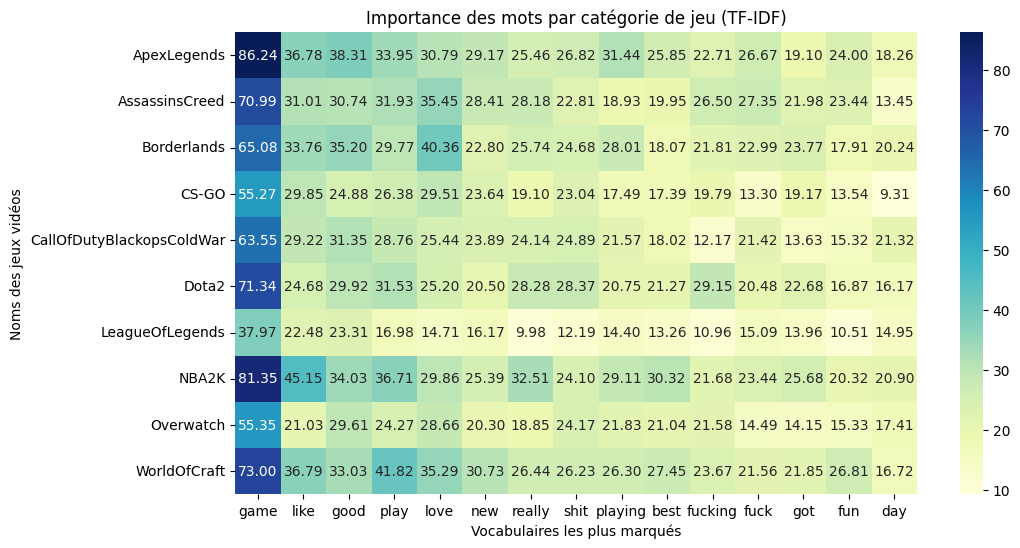

In [ ]:
plt.figure(figsize=(11, 6))
sns.heatmap(tfidf_grouped_top, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Importance des mots par catégorie de jeu (TF-IDF)")
plt.xlabel("Vocabulaires les plus marqués")
plt.savefig("graphes/Best_Vocabulary_sentimental_by_game.png")
plt.ylabel("Noms des jeux vidéos")
plt.show()

## Entrainement et choix des modèles de Machine Learning

#### Procédure d'Encodage des catégories de sentiments

In [40]:
# Encodage des catégories
sentiments = LabelEncoder()
df['sentiment_category_encoded'] = sentiments.fit_transform(df['sentiment_category'])
y = df['sentiment_category_encoded']

In [41]:
df.head()

,game_category,sentiment_category,Tweet,tweet_clean,sentiment_category_encoded
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder,2
1,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill,2
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill,2
3,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder,2
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder,2


### Validation croisée pour déterminer la meilleure performance du modèle
Derniers relevés pour le choix du modèle:

Logistic Regression <br>
Cross-validation scores: [0.69, 0.68, 0.69, 0.68, 0.68] <br>
Mean cross-validation score: 0.68 <br>
Test score: 0.68 <br>

Random Forest <br>
Cross-validation scores: [0.84, 0.83, 0.84, 0.83, 0.84] <br>
Mean cross-validation score: 0.84 <br>
Test score: 0.85 <br>

MultinomialNB
Cross-validation scores: [0.68, 0.66, 0.67, 0.66, 0.66] <br>
Mean cross-validation score: 0.67 <br>
Test score: 0.67 <br>

In [42]:
# Initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB()
}

# Train and evaluate classifiers with cross-validation
for clf_name, clf in classifiers.items():
    print(clf_name)
    # Perform cross-validation
    cv_scores = cross_val_score(clf, X_train_vec, y_train, cv=5, scoring="accuracy")
    # Convertir en floats natifs et arrondir à 2 décimales
    cv_scores_rounded = [round(float(score), 2) for score in cv_scores]  
    print(f"Cross-validation scores: {cv_scores_rounded}")
    print(f"Mean cross-validation score: {round(float(cv_scores.mean()), 2)}")  # Arrondir la moyenne

    # Fit the classifier on the entire training set
    clf.fit(X_train_vec, y_train)

    # Evaluate the classifier on the validation set
    test_score = clf.score(X_val_vec, y_val)
    print(f"Test score: {round(float(test_score), 2)}\n")  # Arrondir le score test R2

Logistic Regression
Cross-validation scores: [0.69, 0.68, 0.69, 0.68, 0.68]
Mean cross-validation score: 0.68
Test score: 0.68

Random Forest
Cross-validation scores: [0.84, 0.83, 0.85, 0.83, 0.83]
Mean cross-validation score: 0.84
Test score: 0.85

MultinomialNB
Cross-validation scores: [0.68, 0.66, 0.67, 0.66, 0.66]
Mean cross-validation score: 0.67
Test score: 0.67



### Validation croisée alternée par RandomizedSearchCV pour déterminer les meilleurs hyperparamètres

Durée estimée: 5-7 min pour calculer le nombre de combinaisons possibles

In [ ]:
# Définir les hyperparamètres à tester
param_distributions = {
    'n_estimators': randint(100, 200),  # Distribution pour le nombre d'arbres
    'max_depth': [None, 6],            # Valeurs fixes possibles
    'min_samples_split': randint(2, 4),  # Distribution pour le nombre minimal d'échantillons
    'min_samples_leaf': randint(1, 3)    # Distribution pour les feuilles
}

# Instanciation du modèle
rf_model = RandomForestClassifier()

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=10,                 # Nombre d'échantillons aléatoires à tester
    scoring='accuracy',        # Métrique d'évaluation sur l'accuracy
    cv=5,                      # Validation croisée avec 5 folds
    random_state=42,           # Pour la reproductibilité
    n_jobs=2                   # Utilisation de 2 coeurs
)

# Entraînement de RandomizedSearchCV
random_search.fit(X_train_vec, y_train)

# Obtenir les meilleurs paramètres et le meilleur score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", round(best_score,2))

### Evaluation du modèle pour le jeu de training, de test et de validation 

In [ ]:
# Modèle
model = RandomForestClassifier(**best_params)
model.fit(X_train_vec, y_train)

# Prédictions
y_train_pred = model.predict(X_train_vec)
y_val_pred = model.predict(X_val_vec)
y_test_pred = model.predict(X_test_vec)

train_accuracy = accuracy_score(y_train, y_train_pred) #Jeu d'Entrainement 80%
val_accuracy = accuracy_score(y_val, y_val_pred) #Jeu de validation 20%
test_accuracy = accuracy_score(y_test, y_test_pred) #Jeu de test 

print("Training Accuracy:", round(train_accuracy,2))
print("Validation Accuracy:", round(val_accuracy,2))
print("Testing Accuracy:", round(test_accuracy,2))

Training Accuracy: 0.94
Validation Accuracy: 0.85
Testing Accuracy: 0.92


### Représentation graphique du modèle de l'arbre de décision

On affichera sur une profondeur de 4 pour comprendre l'intérêt du modèle ce qui a été réparti sur notre analyse du modèle

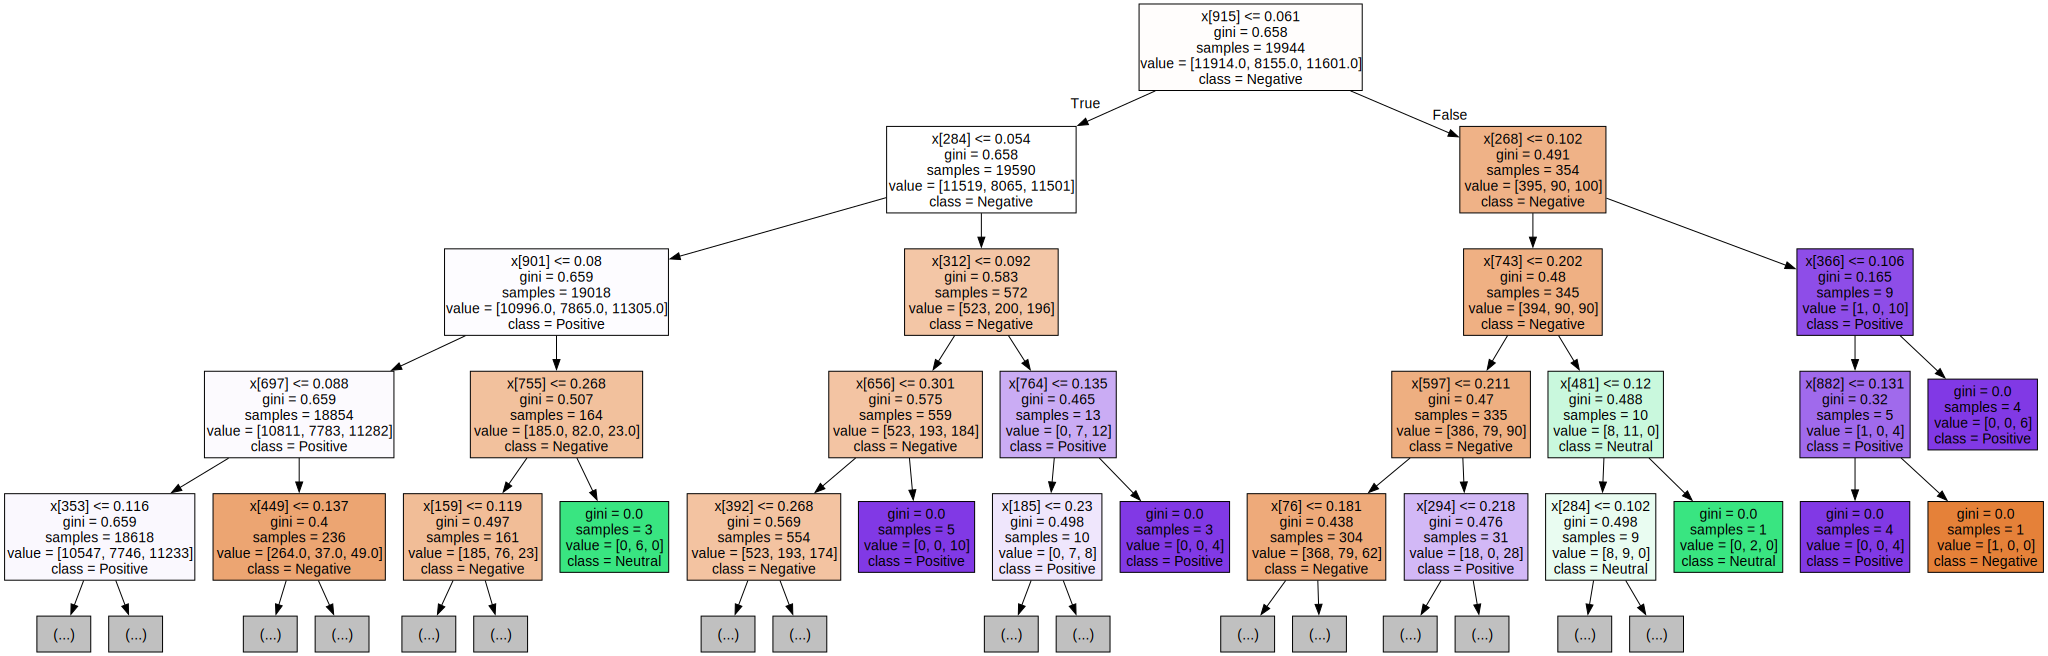

In [ ]:
# Extraire un arbre individuel du RandomForest
single_tree = model.estimators_[0]

# Générer le fichier DOT avec des noms de classes
dot_data = export_graphviz(
    single_tree, 
    filled=True, 
    max_depth=4,  # Profondeur de l'arbre pour notre affichage
    class_names=model.classes_  # Labels de classe 
)

# Créer et afficher l'arbre de décision
graph = graphviz.Source(dot_data)
graph  

### Performance des Modèles de Classification

Derniers relevés

#### **Négatif**
| Métrique                | Valeur |
|-------------------------|--------|
| **Vrais positifs (TP)** | 168    |
| **Faux positifs (FP)**  | 11     |
| **Faux négatifs (FN)**  | 16     |
| **Précision**           | 0.938  |
| **Rappel**              | 0.913  |

**Calculs:**
- Précision: (168 / (168 + 13)) = 0.928
- Rappel: (168 / (168 + 15)) = 0.913

#### **Neutre**
| Métrique                | Valeur |
|-------------------------|--------|
| **Vrais positifs (TP)** | 158    |
| **Faux positifs (FP)**  | 7      |
| **Faux négatifs (FN)**  | 21     |
| **Précision**           | 0.957  |
| **Rappel**              | 0.882  |

**Calculs:**
- Précision: (156 / (156 + 8)) = 0.951
- Rappel: (156 / (156 + 23)) = 0.871

#### **Positif**
| Métrique                | Valeur |
|-------------------------|--------|
| **Vrais positifs (TP)** | 195    |
| **Faux positifs (FP)**  | 26     |
| **Faux négatifs (FN)**  | 7      |
| **Précision**           | 0.882  |
| **Rappel**              | 0.965  |

**Calculs:**
- Précision: (195 / (195 + 26)) = 0.883
- Rappel: (195 / (195 + 9)) = 0.955

#### **Accuracy Totale**

**Calcul:**
Accuracy = ((168 + 156 + 195) / ((168 + 11 + 16) + (158 + 7 + 21) + (197 + 26 + 7))) = 0.917 

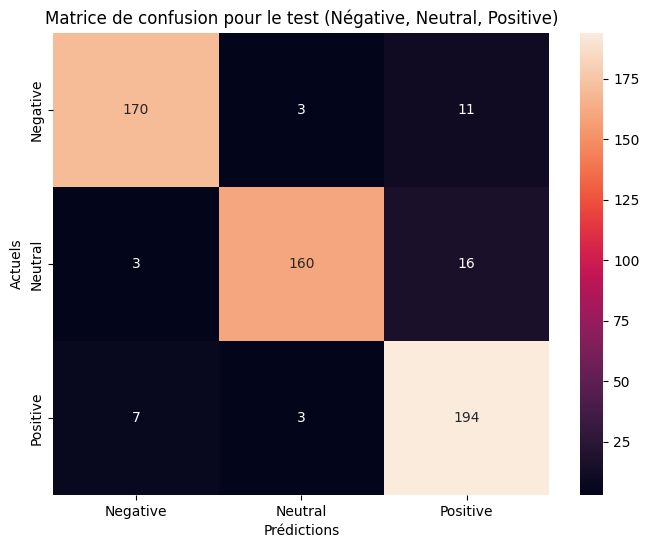

In [ ]:
conf_mat = confusion_matrix(y_test, y_test_pred)
categories = ["Negative","Neutral","Positive"]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=categories, yticklabels=categories)
plt.title("Matrice de confusion pour le test (Négative, Neutral, Positive)")
plt.xlabel("Prédictions")
plt.ylabel("Actuels")
plt.show()

### Classification report Training

In [ ]:
print(classification_report(y_train, y_train_pred, target_names=sentiments.classes_))

              precision    recall  f1-score   support

    Negative       0.98      0.93      0.95     11929
     Neutral       0.97      0.90      0.94      8193
    Positive       0.89      0.97      0.93     11548

    accuracy                           0.94     31670
   macro avg       0.95      0.94      0.94     31670
weighted avg       0.94      0.94      0.94     31670



### Classification report Validation

In [ ]:
# Rapport de classification
print(classification_report(y_val, y_val_pred, target_names=sentiments.classes_))

              precision    recall  f1-score   support

    Negative       0.88      0.87      0.87      3057
     Neutral       0.87      0.75      0.81      2091
    Positive       0.80      0.89      0.84      2770

    accuracy                           0.85      7918
   macro avg       0.85      0.84      0.84      7918
weighted avg       0.85      0.85      0.85      7918



### Classification report Testing

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=sentiments.classes_))

              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93       184
     Neutral       0.96      0.89      0.93       179
    Positive       0.88      0.95      0.91       204

    accuracy                           0.92       567
   macro avg       0.93      0.92      0.92       567
weighted avg       0.93      0.92      0.92       567



In [ ]:
df_val["prediction_sentiment"] = model.predict(X_test_vec)
df_val.head()

,game_category,sentiment_category,Tweet,tweet_clean,prediction_sentiment
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmaking full closet hacking truly awf...,Negative
5,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...,hi madeleine mccann cellar past year little sn...,Negative
6,MaddenNFL,Positive,Thank you @EAMaddenNFL!! \n\nNew TE Austin Hoo...,thank new te austin hooper orange brown pic tw...,Positive
7,TomClancysRainbowSix,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ...",rocket league sea thief rainbow six siege love...,Positive
8,AssassinsCreed,Positive,my ass still knee-deep in Assassins Creed Odys...,still knee deep assassin creed odyssey way any...,Positive


### Visualisation des résultats prédits et réelles

In [ ]:
nb_actual_sent = df_val['sentiment_category'].value_counts()
nb_pred_sent = df_val['prediction_sentiment'].value_counts()

print(nb_actual_sent)
print(nb_pred_sent)

sentiment_category
Positive    204
Negative    184
Neutral     179
Name: count, dtype: int64
prediction_sentiment
Positive    221
Negative    180
Neutral     166
Name: count, dtype: int64


### Comparaison au total des sentiments réelles vs prédits

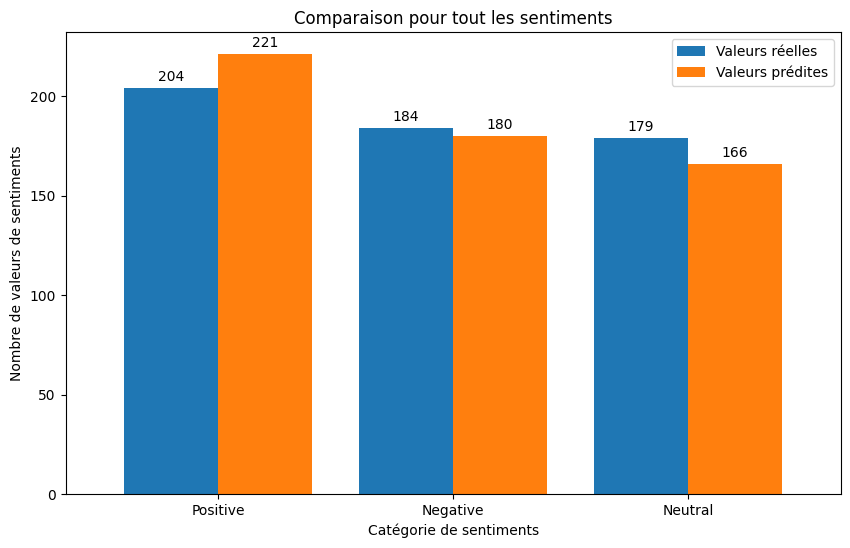

In [ ]:
# Comptage des valeurs réelles et des valeurs prédites
df_comparison = pd.concat([nb_actual_sent,nb_pred_sent], axis=1)

# Créer le graphique avec des barres groupées
ax = df_comparison.plot(kind='bar', width=0.8, figsize=(10, 6))

# Ajouter des labels et un titre
plt.title('Comparaison pour tout les sentiments')
plt.xlabel('Catégorie de sentiments')
plt.ylabel('Nombre de valeurs de sentiments')
plt.xticks(rotation=0)

# Ajouter les valeurs au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)
plt.legend(['Valeurs réelles', 'Valeurs prédites'], loc='upper right')
plt.show()

In [ ]:
real_sentiments = df_val.groupby(['game_category', 'sentiment_category']).size().unstack(fill_value=0)
predicted_sentiments = df_val.groupby(['game_category', 'prediction_sentiment']).size().unstack(fill_value=0)
combined_sentiments = real_sentiments.join(predicted_sentiments, lsuffix='_real', rsuffix='_predict').reset_index()

In [ ]:
combined_sentiments.head()

,game_category,Negative_real,Neutral_real,Positive_real,Negative_predict,Neutral_predict,Positive_predict
0,ApexLegends,6,17,10,5,17,11
1,AssassinsCreed,4,4,24,4,3,25
2,Battlefield,7,4,3,6,4,4
3,Borderlands,5,12,14,5,12,14
4,CS-GO,2,13,9,2,11,11


### Répartition des sentiments (Negative, Neutral, Positive) pour chaque type de jeu dans l'ordre alphabétique

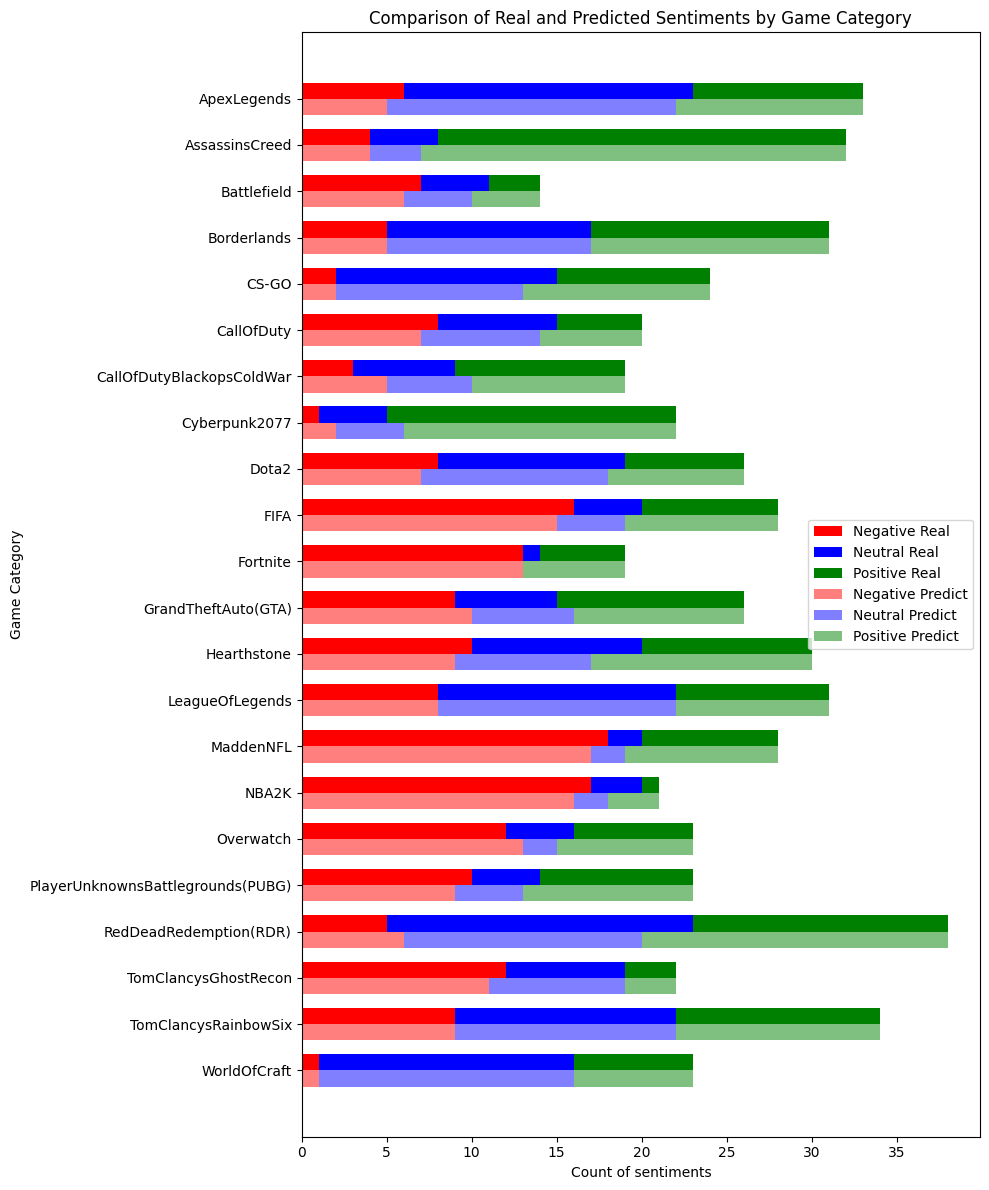

In [ ]:
# Configuration du graphique
combined_sentiments = combined_sentiments.sort_values(by='game_category', ascending=False)

categories = combined_sentiments['game_category']
y = np.arange(len(categories)) 
height = 0.35

fig, ax = plt.subplots(figsize=(10, 12))

ax.barh(y + height/2, combined_sentiments['Negative_real'], height, label='Negative Real', color='r')
ax.barh(y + height/2, combined_sentiments['Neutral_real'], height, left=combined_sentiments['Negative_real'], label='Neutral Real', color='b')
ax.barh(y + height/2, combined_sentiments['Positive_real'], height, left=combined_sentiments['Negative_real']+combined_sentiments['Neutral_real'], label='Positive Real', color='g')

ax.barh(y - height/2, combined_sentiments['Negative_predict'], height, label='Negative Predict', color='r', alpha=0.5)
ax.barh(y - height/2, combined_sentiments['Neutral_predict'], height, left=combined_sentiments['Negative_predict'], label='Neutral Predict', color='b', alpha=0.5)
ax.barh(y - height/2, combined_sentiments['Positive_predict'], height, left=combined_sentiments['Negative_predict']+combined_sentiments['Neutral_predict'], label='Positive Predict', color='g', alpha=0.5)

# Ajout des labels, titre et légende
ax.set_xlabel('Count of sentiments')
ax.set_ylabel('Game Category')
ax.set_title('Comparison of Real and Predicted Sentiments by Game Category')
ax.set_yticks(y)
ax.set_yticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

### Interprétabilité du modèle de Machine Learning

On souhaite d'intepréter notre modèle pour vérifier si les classes (Neutre, Positive et Négative) ont été bien prédits par rapport
aux mots qui sont utilisés

Durée: Moins de 5 minutes

In [ ]:
X_train_dense = X_train_vec.toarray()
X_test_dense = X_test_vec.toarray()

explainer = shap.TreeExplainer(model, X_train_dense, feature_names=vectorizer.get_feature_names_out())
shap_values = explainer.shap_values(X_test_dense)

100%|===================| 1700/1701 [04:42<00:00]        

Les shap_values que vous avez obtenus ont une forme de (567, 1000, 3). Cela signifie : <br>
567 : Le nombre d'échantillons dans votre ensemble de validation (X_val_dense). <br>
1000 : Le nombre de caractéristiques (features) utilisées par le modèle. <br>
3 : Le nombre de classes (neutre, positive, négative). <br>

Pour chaque échantillon, chaque caractéristique a une valeur SHAP pour chaque classe. Ces valeurs indiquent comment chaque caractéristique contribue à la prédiction pour chaque classe. <br>

Mise en forme du shap_values: shap_values[échantillon][caractéristique][classe] <br>

In [ ]:
print("shap_values", shap_values.shape)

shap_values (567, 1000, 3)


In [ ]:
df

,game_category,sentiment_category,Tweet,tweet_clean,sentiment_category_encoded
0,Borderlands,Positive,im getting on borderlands and i will murder yo...,getting borderland murder,2
1,Borderlands,Positive,I am coming to the borders and I will kill you...,coming border kill,2
2,Borderlands,Positive,im getting on borderlands and i will kill you ...,getting borderland kill,2
3,Borderlands,Positive,im coming on borderlands and i will murder you...,coming borderland murder,2
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,getting borderland murder,2
...,...,...,...,...,...
72379,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point ift.tt /...,tom clancy ghost recon choke point ift tt qwteh,1
72380,TomClancysGhostRecon,Neutral,Tom Clancy's Ghost Recon: Choke Point i.tt / 3...,tom clancy ghost recon choke point tt qwteh,1
72381,TomClancysGhostRecon,Neutral,Tom lin Ghost Recon: Choke Point ift.tt/36QWteH,tom lin ghost recon choke point ift tt qwteh,1
72382,TomClancysGhostRecon,Neutral,In Tom Clancy'A s The Ghost House Recon : Chok...,tom clancy ghost house recon choke point ift t...,1


In [ ]:
shap_values_positive = shap_values[:, :, 2]  # Classe positive (indice 2)
shap_values_neutral = shap_values[:, :, 1]  # Classe neutre (indice 1)
shap_values_negative = shap_values[:, :, 0]  # Classe négative (indice 0)

### Classe positive

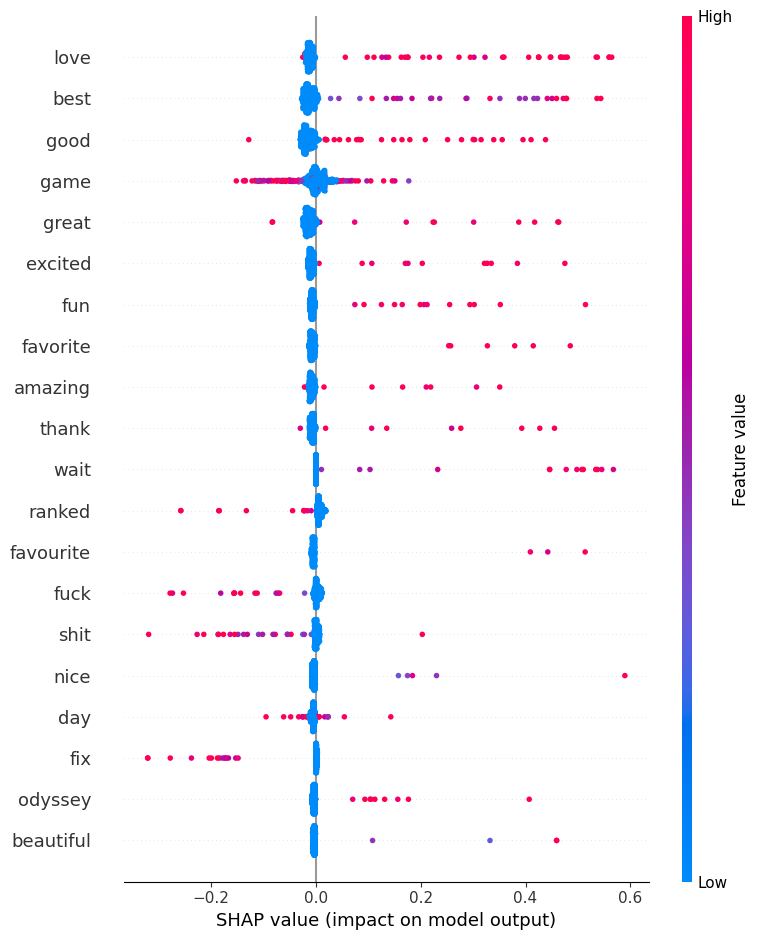

In [ ]:
shap.summary_plot(shap_values_positive, X_test_dense, feature_names=vectorizer.get_feature_names_out())

### Classe Négative

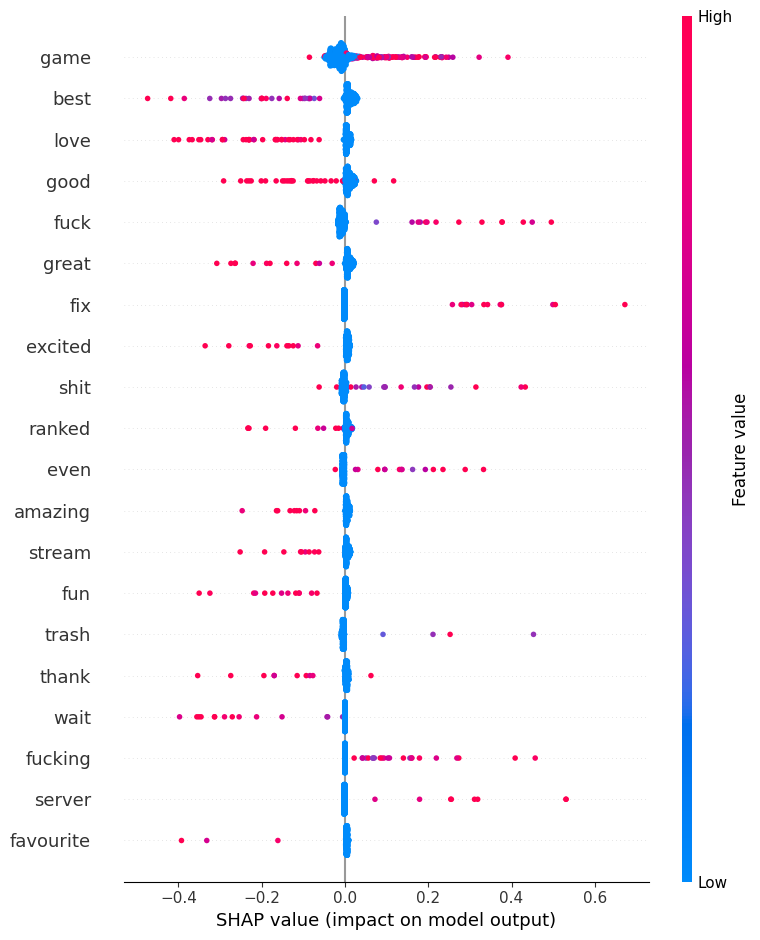

In [ ]:
shap.summary_plot(shap_values_negative, X_test_dense, feature_names=vectorizer.get_feature_names_out())

### Classe Neutre

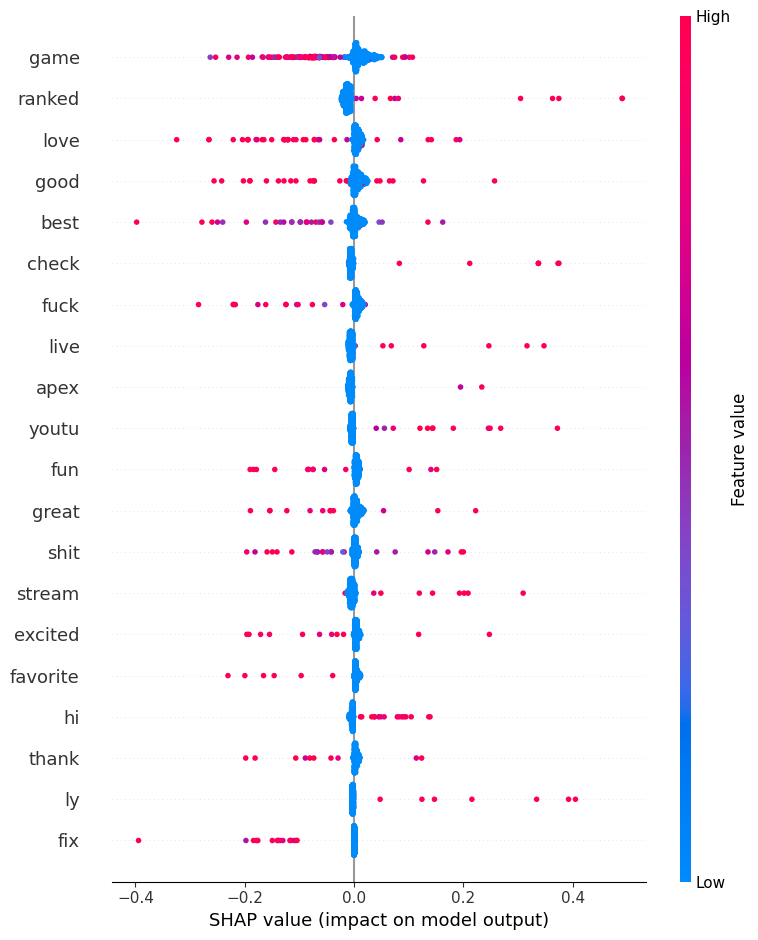

In [ ]:
shap.summary_plot(shap_values_neutral, X_test_dense, feature_names=vectorizer.get_feature_names_out())